In [1]:
# %% 라이브러리
import os
import time
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

In [2]:
# %% 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./Dirty/"
batch_size = 32
num_classes = 6
epochs = 15
lr = 1e-4
patience = 3
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

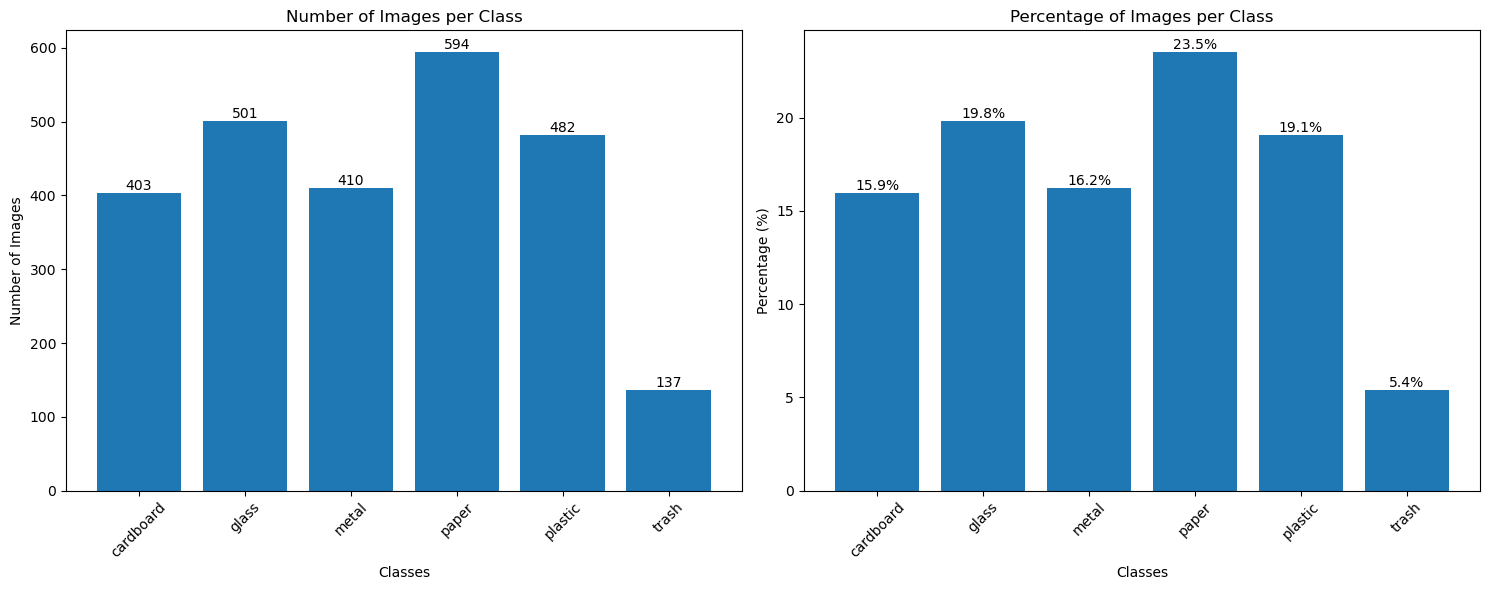


Class Distribution Statistics:
Total number of images: 2527
Average images per class: 421.2
Standard deviation: 142.1

Class-wise breakdown:
cardboard: 403 images (15.9%)
glass: 501 images (19.8%)
metal: 410 images (16.2%)
paper: 594 images (23.5%)
plastic: 482 images (19.1%)
trash: 137 images (5.4%)

Imbalance ratio (max/min): 4.34


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.datasets import ImageFolder
import numpy as np

def plot_class_distribution(data_dir):
    # 데이터셋 로드
    dataset = ImageFolder(data_dir)
    
    # 클래스별 이미지 개수 계산
    class_names = dataset.classes
    class_counts = []
    for class_idx, class_name in enumerate(class_names):
        count = sum(1 for x in dataset.targets if x == class_idx)
        class_counts.append(count)
    
    # 전체 데이터 수
    total_images = sum(class_counts)
    
    # 1. 막대 그래프
    plt.figure(figsize=(15, 6))
    
    # 첫 번째 서브플롯: 실제 개수
    plt.subplot(1, 2, 1)
    bars = plt.bar(class_names, class_counts)
    plt.title('Number of Images per Class')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    
    # 막대 위에 숫자 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    
    # 두 번째 서브플롯: 비율
    plt.subplot(1, 2, 2)
    class_percentages = [count/total_images * 100 for count in class_counts]
    bars = plt.bar(class_names, class_percentages)
    plt.title('Percentage of Images per Class')
    plt.xlabel('Classes')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    
    # 막대 위에 퍼센트 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('../12th_project/plot.png')
    plt.show()
    
    # 2. 클래스 균형 통계 출력
    print("\nClass Distribution Statistics:")
    print(f"Total number of images: {total_images}")
    print(f"Average images per class: {np.mean(class_counts):.1f}")
    print(f"Standard deviation: {np.std(class_counts):.1f}")
    print("\nClass-wise breakdown:")
    for class_name, count, percentage in zip(class_names, class_counts, class_percentages):
        print(f"{class_name}: {count} images ({percentage:.1f}%)")
    
    # 3. 불균형 정도 계산 (최대/최소 비율)
    imbalance_ratio = max(class_counts) / min(class_counts)
    print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}")

# 사용 예시
plot_class_distribution('./Dirty/')

In [3]:
# %% 전처리
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
# %% 데이터셋 불러오기
dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# %% 모델 정의 (ResNet18)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# %% 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [ ]:
# %% 학습 함수 (조기 종료 + test 평가 포함)
def train_model():
    best_val_loss = float('inf')
    counter = 0
    best_epoch = 0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total * 100

        # 검증
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, val_predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (val_predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total * 100

        # 테스트 평가
        test_loss, test_correct, test_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, test_predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (test_predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader.dataset)
        test_acc = test_correct / test_total * 100

        print(f"[Epoch {epoch+1}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            counter = 0
            torch.save(model.state_dict(), "Resnet18_best_model.pt")
        else:
            counter += 1
            if counter >= patience:
                print("조기 종료 triggered.")
                break

    print(f"\n최적 모델은 {best_epoch}번째 에포크에서 저장되었습니다.")

# %% 평가 함수
def evaluate_model():
    model.load_state_dict(torch.load("Resnet18_best_model.pt"))
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = accuracy_score(all_labels, all_preds)

    print(f"\n테스트 손실: {test_loss:.4f}")
    print(f"테스트 정확도: {test_acc * 100:.2f}%")
    print("\n성능 평가표:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


학습 시작
[Epoch 1] Train Loss: 0.6795, Train Acc: 76.15% | Val Loss: 0.4977, Val Acc: 82.54% | Test Loss: 0.3829, Test Acc: 86.61%
[Epoch 2] Train Loss: 0.1474, Train Acc: 96.68% | Val Loss: 0.4430, Val Acc: 84.92% | Test Loss: 0.2599, Test Acc: 88.98%
[Epoch 3] Train Loss: 0.0609, Train Acc: 98.81% | Val Loss: 0.3892, Val Acc: 86.90% | Test Loss: 0.2614, Test Acc: 90.94%
[Epoch 4] Train Loss: 0.0431, Train Acc: 99.26% | Val Loss: 0.4353, Val Acc: 84.92% | Test Loss: 0.2339, Test Acc: 91.34%
[Epoch 5] Train Loss: 0.0282, Train Acc: 99.36% | Val Loss: 0.4477, Val Acc: 86.90% | Test Loss: 0.2546, Test Acc: 90.94%
[Epoch 6] Train Loss: 0.0209, Train Acc: 99.65% | Val Loss: 0.4534, Val Acc: 86.51% | Test Loss: 0.2468, Test Acc: 90.55%
조기 종료 triggered.

📦 최적 모델은 3번째 에포크에서 저장되었습니다.

총 학습 시간: 1746.15초

모델 평가 시작


C:\Users\KDP38\AppData\Local\Temp\ipykernel_14368\1729495338.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Resnet18_best_model.pt"))


테스트 손실: 0.2614
테스트 정확도: 90.94%

성능 평가표:
              precision    recall  f1-score   support

   cardboard       0.97      0.93      0.95        41
       glass       0.91      0.94      0.92        52
       metal       0.79      0.92      0.85        37
       paper       0.92      1.00      0.96        56
     plastic       0.96      0.82      0.88        55
       trash       0.90      0.69      0.78        13

    accuracy                           0.91       254
   macro avg       0.91      0.88      0.89       254
weighted avg       0.91      0.91      0.91       254



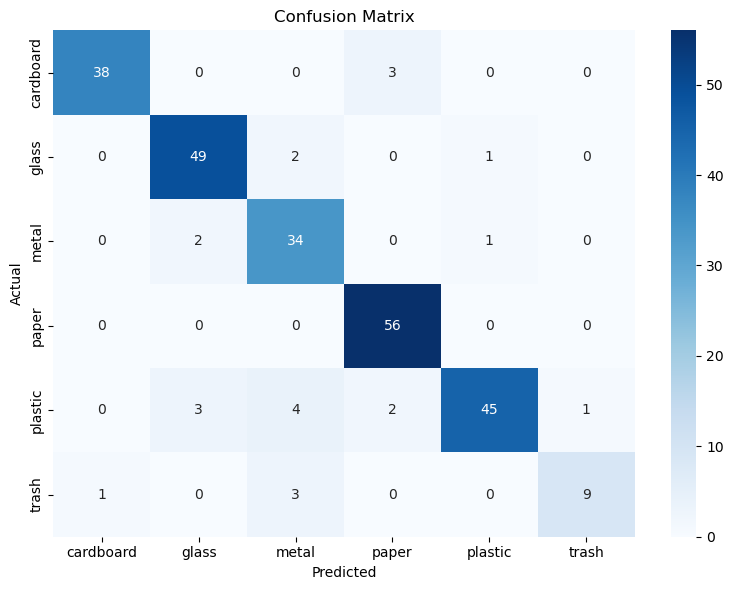

In [7]:
# %% 이미지 예측 함수
def predict_image_full(image_path, model, device):
    inference_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    input_tensor = inference_transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.softmax(output, dim=1)[0]
        pred_idx = torch.argmax(prob).item()
        pred_label = class_names[pred_idx]
        confidence = prob[pred_idx].item()

    print(f"\n예측 결과: {pred_label.upper()} (신뢰도: {confidence:.2%})")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {pred_label} ({confidence:.2%})")
    plt.show()
    return pred_label

# %% 실행
print("\n학습 시작")
start = time.time()
train_model()
print(f"\n총 학습 시간: {time.time() - start:.2f}초")

print("\n모델 평가 시작")
evaluate_model()


예측 결과: METAL (신뢰도: 87.78%)


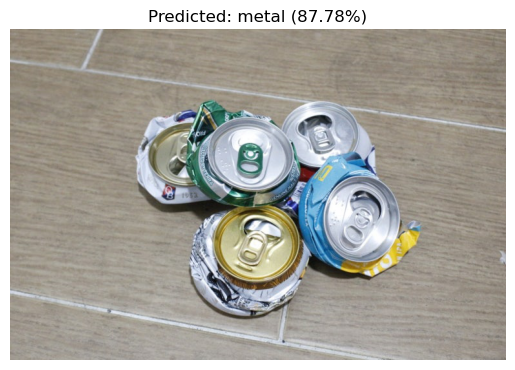

'metal'

In [11]:
# 예측 테스트
image_path = "../12th_project/test/can2.jpg"
predict_image_full(image_path, model, device)


예측 결과: PLASTIC (신뢰도: 79.69%)


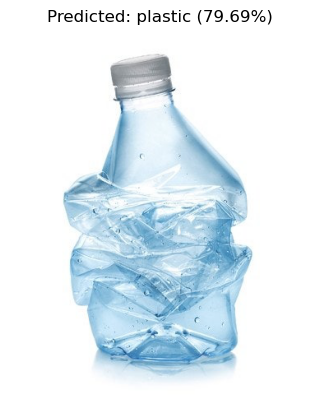

'plastic'

In [12]:
# 예측 테스트
image_path = "../12th_project/test/plastic2.jpg"
predict_image_full(image_path, model, device)


예측 결과: PLASTIC (신뢰도: 74.65%)


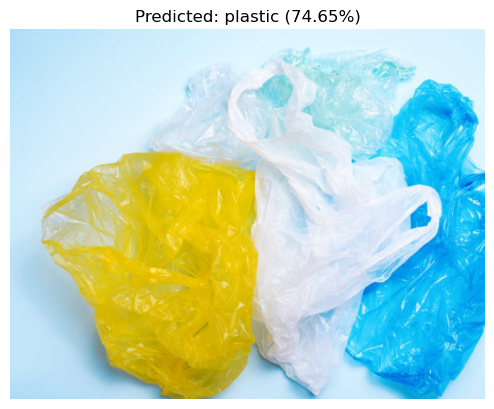

'plastic'

In [13]:
# 예측 테스트
image_path = "../12th_project/test/vinyl.jpg"
predict_image_full(image_path, model, device)